In [34]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import sqlite3
import os
import pandasql
from sqlalchemy import create_engine
from tqdm import tqdm
import matplotlib.pyplot as plt

# Functions

0 : Music (400)

1 : personality (44)

2 : Depression (21)

3 : LSRP (psychopathy) (26)

4 : Dark personality (12)

5 : Innocuous (IPQ) (178) : Subtle dark personality

6 : Voice Samples about Suffering (12)

7 : Moral Dilemma (17)

8 : Social discounting (72) : You get 20 dollars vs your mother get 20 dollars

9 : Mood (8)

10 : SECRET : Jury Trial (1)


## Build voice sample dataframe


In [4]:
l = get_mat()

# Initialize an empty DataFrame with the desired columns
voice_df = pd.DataFrame(columns=["Participant ID", "Trial ID", "Task Number", "Instance ID", "Voice Sample"])

for path in tqdm(l, desc="Processing paths", unit="path"):
    mat = loadmat("/content/drive/MyDrive/Machine2/all_mat/" + path)
    allTrials = pd.DataFrame(mat['allTrials'])
    DATA = pd.DataFrame(mat['DATA'])
    p_id = path[:-4]
    mid_3_col = allTrials[allTrials[1] == 6]
    v = [DATA.iloc[i-1][0] for i in allTrials[allTrials[1] == 6][0].values]
    blobs = []
    for item in v:
        binary_data = pickle.dumps(item)
        blobs.append(binary_data)

    # Create a temporary DataFrame for the current path
    temp_df = pd.DataFrame({
        "Participant ID": [p_id] * len(mid_3_col),
        "Trial ID": mid_3_col.iloc[:, 0],
        "Task Number": mid_3_col.iloc[:, 1],
        "Instance ID": mid_3_col.iloc[:, 2],
        "Voice Sample": blobs
    })

    # Append the temporary DataFrame to the final DataFrame
    voice_df = pd.concat([voice_df, temp_df], ignore_index=True)

NameError: name 'get_mat' is not defined

In [ ]:
from scipy.io import wavfile

# Assuming you want to save the first voice sample as a WAV file
first_sample = voice_df['Voice Sample'].iloc[0]  # Get the first blob

# Unpickle the blob to get the original array
sample_array = pickle.loads(first_sample)

# Convert the array to a numpy array
sample_np = np.array(sample_array, dtype=np.int16)

# Save the numpy array as a WAV file
sample_rate = 44100  # Assuming a sample rate of 44.1kHz
wavfile.write('first_sample.wav', sample_rate, sample_np)

-- A .wav file should be generated


In [ ]:
mat = loadmat("/content/drive/MyDrive/FoxLabDataTeam/Machine2/all_mat/" + l[85])
allTrials = pd.DataFrame(mat['allTrials'])
allTrials[allTrials[1] == 6]

NameError: name 'l' is not defined

In [ ]:
DATA = pd.DataFrame(mat['DATA'])

In [ ]:
DATA.iloc[64][0].shape

(2707456, 1)

In [52]:
def get_tablenames():
  """
  Retrieves a list of predefined table names.

  Returns:
      list: A list of string values representing table names.
  """
  return ["music", "personality", "depression", "LSRP", "dark", "IPQ", "suffering", "moral", "social", "mood", "jury"]

def get_music_lib():
    """
    Loads and processes music library metadata from an Excel file.

    Processes the metadata by filling missing values, casting columns to integer type,
    and renaming columns for consistency.

    Returns:
      pandas.DataFrame: A dataframe containing processed music library metadata.
    """
    raw_meta = pd.read_excel('MusicTable.xlsx')
    raw_meta[["Genre", "Year"]] =  raw_meta[["Genre", "Year"]].fillna(0).astype(int)
    music_meta = raw_meta.iloc[:, :8]
    music_meta = music_meta.rename(columns = {"Source" : "SourceId",
                                            "Number" : "MusicId",
                                            "Genre" : "GenreId",
                                            "Subgenre/Style" : "Subgenre",
                                            "Clip name" : "Path"})
    music_meta = music_meta[["MusicId", "SourceId", "GenreId", "Subgenre", "Title", "Artist", "Year", "Path"]]

    return music_meta

def get_mat():
  """
  Retrieves a list of file names from a specified directory.

  The directory is expected to contain .mat files.

  Returns:
      list: A list of string values representing file names in the directory.
  """
  return os.listdir("allMat/all_mat")

def get_tables(path):
    """
    Loads MATLAB .mat files, processes participant data, and structures it into clean pandas dataframes.

    Parameters:
      path (str): The path to the .mat file to be processed.

    Returns:
      list: A list of pandas.DataFrame objects, each representing structured participant response data.
    """
    tab_list = []

    mat = loadmat("allMat/all_mat/" + path)

    allTrials = pd.DataFrame(mat['allTrials'])
    DATA = pd.DataFrame(mat['DATA'])
    seed = pd.DataFrame(mat['seed'])
    trainingDATA = pd.DataFrame(mat['trainingDATA'])

    clean_allTrials = allTrials.rename(columns={0: "trialNumber", 1: "taskId", 2: "instanceId"})
    clean_allTrials["participantId"] = path[:-4]
    clean_allTrials = clean_allTrials[["participantId", "trialNumber", "taskId", "instanceId"]]

    for i in range(11):
        Trials = clean_allTrials[clean_allTrials["taskId"] == i]
        Trials.index = range(len(Trials))
        Res = DATA.iloc[Trials["trialNumber"] - 1]
        Res = pd.DataFrame([Res.iloc[i].to_numpy()[0][0] for i in range(len(Res))])
        Res = Res.rename(columns={i: "feature" + str(i) for i in range(len(Res.columns))})
        full_Res = pd.concat([Trials, Res], axis=1)

        dirty_col = [col for col in full_Res.columns[1:] if full_Res[col].dtype == np.ndarray]
        str_col = [cc for cc in dirty_col if type(full_Res[cc][0][0]) == np.str_]
        num_col = [cc for cc in dirty_col if type(full_Res[cc][0][0]) != np.str_]

        for c1 in str_col:
            str_list = [i[0] if type(i) == type(np.array([])) else "None" for i in full_Res[c1]]
            full_Res[c1] = str_list

        for c2 in num_col:
            num_list = [i[0][0] if type(i) == type(np.array([])) else -1 for i in full_Res[c2]]
            full_Res[c2] = num_list

        tab_list.append(full_Res)

    return clean_tables(tab_list)

def clean_tables(tab_list):
    """
    Renames columns of dataframes in the provided list according to predefined mapping dictionaries and drops duplicate columns.

    Parameters:
      tab_list (list): A list of pandas.DataFrame objects to be cleaned.

    Returns:
      list: A list of cleaned pandas.DataFrame objects.
    """
    music_response_rename_map = {
      "feature0": "task_id_dup",
      "feature1": "trial_number_dup",
      "feature2": "familiarity",
      "feature3": "rating",
      "feature4": "arousal",
      # Assuming feature 5-15 are one-hot encoded columns for emotions
      "feature5": "joy",
      "feature6": "nostalgia",
      "feature7": "groove",
      "feature8": "awe",
      "feature9": "sadness",
      "feature10": "anxiety",
      "feature11": "disgust",
      "feature12": "anger",
      "feature13": "nothing",
      "feature14": "reflection",
      "feature15": "boredom",
      # Reaction time/"ok" button click time columns
      "feature16": "rating_reaction_time",
      "feature17": "familiarity_reaction_time",
      "feature18": "arousal_reaction_time",
      "feature19": "emotion_reaction_time",
    }

    personality_rename_map = {
      "feature0": "question",
      "feature1": "question_dup",
      "feature2": "agreement_level",
      "feature3": "reaction_time",
    }

    depression_rename_map = {
      "feature0": "task_id_dup",
      "feature1": "trial_number_dup",
      "feature2": "instance_id_dup",
      "feature3": "agreement_level",
      "feature4": "reaction_time",
    }

    lsrp_rename_map = {
      "feature0": "question",
      "feature1": "question_dup",
      "feature2": "agreement_level",
      "feature3": "reaction_time",
    }

    dark_personality_rename_map = {
      "feature0": "question",
      "feature1": "question_dup",
      "feature2": "agreement_level",
      "feature3": "reaction_time",
    }

    suffer_rename_map = {

    }

    IPQ_rename_map = {
      "feature0": "question",
      "feature1": "question_dup",
      "feature2": "agreement_level",
      "feature3": "reaction_time",
    }

    moral_dilemma_rename_map = {
      "feature0": "task_id_dup",
      "feature1": "trial_number_dup",
      "feature2": "instance_id_dup",
      "feature3": "choice",
      "feature4": "guilt_level",
      # Assuming feature 5-12 are one-hot encoded columns for justifications
      "feature5": "moral_justification",
      "feature6": "legal_justification",
      "feature7": "religious_justification",
      "feature8": "utilitarian_justification",
      "feature9": "sympathy_justification",
      "feature10": "intuition_justification",
      "feature11": "non_involvement_justification",
      "feature12": "dummy_justification",
      "feature13": "previously_seen",
      "feature14": "independent_variable_level",
      "feature15": "reaction_time",
    }

    social_discounting_rename_map = {
      "feature0": "social_distance",
      "feature1": "reward",
      # Slider settings
      "feature2": "participant_response",
      "feature3": "original_placement",
      "feature4": "reaction_time",
    }

    mood_rename_map = {
      "feature0": "task_id_dup",
      "feature1": "trial_number_dup",
      # Slider settings
      "feature2": "enjoyment",
      "feature3": "fatigue",
      "feature4": "engagement",
      "feature5": "distress",
      # Original slider settings
      "feature6": "original_enjoyment",
      "feature7": "original_fatigue",
      "feature8": "original_engagement",
      "feature9": "original_distress",
      "feature10": "reaction_time",
    }

    jury_rename_map = {
      "feature0": "trial_number_dup",
      "feature1": "evidence",
      "feature2": "evidence_dup",  # Double check before dropping
      "feature3": "victim",
      "feature4": "perpetrator",
      "feature5": "guilty",
      "feature6": "confidence",
    }

    dict_list = [music_response_rename_map, personality_rename_map, depression_rename_map,
              lsrp_rename_map, dark_personality_rename_map, IPQ_rename_map,
              suffer_rename_map, moral_dilemma_rename_map, social_discounting_rename_map, mood_rename_map, jury_rename_map]

    for idx in range(len(dict_list)):
        tab_list[idx].rename(columns=dict_list[idx], inplace=True)
        # Identify columns to drop by checking for '_dup' in the new column names
        cols_to_drop = [col for col in tab_list[idx].columns if '_dup' in col]
        # Drop the identified duplicate columns
        tab_list[idx].drop(columns=cols_to_drop, inplace = True)

    return tab_list

def create_db(df_list):
    """
    Initializes a connection to an SQLite database and potentially creates tables from dataframes.

    Parameters:
      df_list (list): A list of pandas.DataFrame objects to be stored in the database.
    """
    machine2 = create_engine('sqlite:////content/drive/MyDrive/FoxLabDataTeam/Machine2/Machine2.db')

In [16]:
record_list = [[] for i in range(11)]
path_list = get_mat()
for p in tqdm(path_list):
    try:
        tmp = get_tables(p)
        for i in range(11):
            record_list[i].append(tmp[i])
    except:
        pass

for i in range(11):
    record_list[i] = pd.concat(record_list[i]).reset_index()

100%|██████████████████████████████████████████████████████████████████████████████| 1075/1075 [03:19<00:00,  5.38it/s]


In [19]:
record_list[2]

,index,participantId,trialNumber,taskId,instanceId,agreement_level,reaction_time
0,0,97f4_7385706431,89,2,11,NaN,NaN
1,1,97f4_7385706431,105,2,2,NaN,NaN
2,2,97f4_7385706431,111,2,5,NaN,NaN
3,3,97f4_7385706431,147,2,8,NaN,NaN
4,4,97f4_7385706431,153,2,6,NaN,NaN
...,...,...,...,...,...,...,...
22502,16,zzru_7377077714,545,2,12,2,5.747
22503,17,zzru_7377077714,571,2,11,1,5.549
22504,18,zzru_7377077714,593,2,9,0,6.685
22505,19,zzru_7377077714,671,2,17,0,3.739


In [20]:
for i in range(11):
    record_list[i] = record_list[i].drop(columns = "index")

In [21]:
record_list[0].rename(columns = {"nothing" : "no_emotion"}, inplace = True)

In [22]:
machine2 = create_engine('sqlite:///machine2_new_aug.db')
tab_names = get_tablenames()
# Convert the DataFrame to an SQL table and save into machine2.db
for idx in range(len(record_list)):
    record_list[idx].to_sql(tab_names[idx], machine2, if_exists='replace', index=False) # (updated by Tom Mar 21)

In [ ]:
# first step
# len(all_mat_files) = ~1000
# len(all_mat_files[i]) = 11
# stacked_tab_list = []

# for i in range(0):
#   stacked_tab_list.append(pd.concat([all_mat_files[j][0] for j in range(~1000)]))

# len(stacked_tab_list) = 11
# stacked_tab_list --> .db file

# Second step: distributed system?
# Third step: UI

In [ ]:
tab_list = get_tables(get_mat()[0])
len(tab_list)

11

In [ ]:
tab_list[0].taskId[0]
# for voice samples, use blob

0

In [53]:
get_music_lib()

,MusicId,SourceId,GenreId,Subgenre,Title,Artist,Year,Path
0,1,1,1,Medieval,Je Vous Pri Que J'Aye un Baysier,Richard Loqueville,1418,0001_richardLoqueville_jeVousPriQueJAyeUnBaysi...
1,2,1,1,Baroque,Four Seasons: Concerto No. 2 in G Minor,Antonio Vivaldi,1721,0002_antonioVivaldi_fourSeasonsConcertoNo2InGM...
2,3,1,1,Classical,Requiem in D Minor,Wolfgang Amadeus Mozart,1791,0003_wolfgangAmadeusMozart_requiemInDMinor.mp4
3,4,1,1,Opera,Nessun Dorma,Luciano Pavarotti,1926,0004_lucianoPavarotti_nessunDorma.mp4
4,5,1,2,Bluegrass,Blue Moon of Kentucky,Bill Monroe,1947,0005_billMonroe_blueMoonOfKentucky.mp4
...,...,...,...,...,...,...,...,...
995,996,5,7,spanish black metal,Stigma Dragon,Spellcraft,2013,0996_spellcraft_stigmaDragon.mp4
996,997,5,3,goa trance,Back To Hyperion - Original Mix,Agneton,2012,0997_agneton_backToHyperionOriginalMix.mp4
997,998,5,9,doujin,Halcyon,XI,2013,0998_xi_halcyon.mp4
998,999,5,3,deep neo-synthpop,Strange,No Decay,1997,0999_noDecay_strange.mp4


# Import Data from .mat file

In [ ]:
path = "nydt_7389415331.mat"
mat = loadmat("/content/drive/MyDrive/FoxLabDataTeam/Machine2/all_mat/" + path)

allTrials = pd.DataFrame(mat['allTrials'])
DATA = pd.DataFrame(mat['DATA'])
seed = pd.DataFrame(mat['seed'])
trainingDATA = pd.DataFrame(mat['trainingDATA'])

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/FoxLabDataTeam/Machine2/all_mat/nydt_7389415331.mat'

In [ ]:
allTrials

,0,1,2
0,1,9,0
1,2,0,354
2,3,5,5
3,4,0,27
4,5,3,25
...,...,...,...
796,797,2,10
797,798,0,103
798,799,8,53
799,800,0,1000


# TODO: Data Cleaning (Please refer to the ERD)

## Clean allTrial Table (updated by Tom 7/21)

In [ ]:
clean_allTrials = allTrials.rename(columns={0: "trialId",
                                            1: "typeId",
                                            2: "taskId"})
clean_allTrials["participantId"] = path[:-4]
clean_allTrials = clean_allTrials[["participantId", "trialId", "typeId", "taskId"]]

In [ ]:
clean_allTrials

,participantId,trialId,typeId,taskId
0,nydt_7389415331,1,9,0
1,nydt_7389415331,2,0,354
2,nydt_7389415331,3,5,5
3,nydt_7389415331,4,0,27
4,nydt_7389415331,5,3,25
...,...,...,...,...
796,nydt_7389415331,797,2,10
797,nydt_7389415331,798,0,103
798,nydt_7389415331,799,8,53
799,nydt_7389415331,800,0,1000


## Clean music response table (updated by Tom 7/21)

In [ ]:
#Codes below clean the musicTrial Table

# select all the music trials (task_type_id = 0)
musicTrials = clean_allTrials[clean_allTrials["typeId"] == 0]

# drop the task type column since they all equal to 0
#musicTrials = musicTrials.drop(["typeId"], axis=1)

# reindex the dataframe
musicTrials.index = range(len(musicTrials))

In [ ]:
musicTrials

,participantId,trialId,typeId,taskId
0,nydt_7389415331,2,0,354
1,nydt_7389415331,4,0,27
2,nydt_7389415331,6,0,492
3,nydt_7389415331,8,0,55
4,nydt_7389415331,10,0,306
...,...,...,...,...
395,nydt_7389415331,792,0,51
396,nydt_7389415331,794,0,320
397,nydt_7389415331,796,0,93
398,nydt_7389415331,798,0,103


In [ ]:
# Codes below clean the musicResponse Table

# Get music response data from the original DATA table
musicRes = DATA.iloc[musicTrials["trialId"] - 1]

# Turn the music response data into pandas df
musicRes = pd.DataFrame([musicRes.iloc[i].to_numpy()[0][0] for i in range(len(musicRes))])

# Rename columns into readable names
musicRes = musicRes.rename(columns={i: "feature" + str(i) for i in range(len(musicRes.columns))})

In [ ]:
musicRes

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19
0,0.0,2.0,1.0,4.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.899,11.171,15.682,28.719
1,0.0,4.0,5.0,6.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.759,11.239,17.367,29.396
2,0.0,6.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.982,13.702,16.470,19.522
3,0.0,8.0,1.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.313,8.585,11.785,15.004
4,0.0,10.0,5.0,7.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.578,7.385,9.106,13.867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,792.0,1.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.008,2.688,3.639,6.520
396,0.0,794.0,5.0,7.0,6.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.014,3.054,4.469,7.015
397,0.0,796.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.231,4.086,4.814,6.623
398,0.0,798.0,5.0,5.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.179,4.379,5.451,7.108


In [ ]:
# Concat the musicTrail Table and the musicResponse Table to create the full Music Response table
full_musicRes = pd.concat([musicTrials, musicRes], axis=1)

In [ ]:
full_musicRes

,participantId,trialId,taskId,feature0,feature1,feature2,feature3,feature4,feature5,feature6,...,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19
0,1490,2,354,0.0,2.0,1.0,4.0,3.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,8.899,11.171,15.682,28.719
1,1490,4,27,0.0,4.0,5.0,6.0,5.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.759,11.239,17.367,29.396
2,1490,6,492,0.0,6.0,1.0,4.0,4.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,11.982,13.702,16.470,19.522
3,1490,8,55,0.0,8.0,1.0,3.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,6.313,8.585,11.785,15.004
4,1490,10,306,0.0,10.0,5.0,7.0,6.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.578,7.385,9.106,13.867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1490,792,51,0.0,792.0,1.0,4.0,5.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2.008,2.688,3.639,6.520
396,1490,794,320,0.0,794.0,5.0,7.0,6.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.014,3.054,4.469,7.015
397,1490,796,93,0.0,796.0,1.0,4.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2.231,4.086,4.814,6.623
398,1490,798,103,0.0,798.0,5.0,5.0,5.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.179,4.379,5.451,7.108


## Clean music_meta table and related tables (updated by Tom 7/21)

In [54]:
# Read from original excel
raw_meta = pd.read_excel('MusicTable.xlsx')

In [55]:
# change genre id and year into int
raw_meta[["Genre", "Year"]] =  raw_meta[["Genre", "Year"]].fillna(0).astype(int)

In [56]:
# Codes below clean the music_meta table

# select columns with music metadata
music_meta = raw_meta.iloc[:, :8]

# read name columns into readable ones
music_meta = music_meta.rename(columns = {"Source" : "SourceId",
                                          "Number" : "MusicId",
                                          "Genre" : "GenreId",
                                          "Subgenre/Style" : "Subgenre",
                                          "Clip name" : "Path"})

# change the order of the dataframe
music_meta = music_meta[["MusicId", "SourceId", "GenreId", "Subgenre", "Title", "Artist", "Year", "Path"]]

In [57]:
music_meta

,MusicId,SourceId,GenreId,Subgenre,Title,Artist,Year,Path
0,1,1,1,Medieval,Je Vous Pri Que J'Aye un Baysier,Richard Loqueville,1418,0001_richardLoqueville_jeVousPriQueJAyeUnBaysi...
1,2,1,1,Baroque,Four Seasons: Concerto No. 2 in G Minor,Antonio Vivaldi,1721,0002_antonioVivaldi_fourSeasonsConcertoNo2InGM...
2,3,1,1,Classical,Requiem in D Minor,Wolfgang Amadeus Mozart,1791,0003_wolfgangAmadeusMozart_requiemInDMinor.mp4
3,4,1,1,Opera,Nessun Dorma,Luciano Pavarotti,1926,0004_lucianoPavarotti_nessunDorma.mp4
4,5,1,2,Bluegrass,Blue Moon of Kentucky,Bill Monroe,1947,0005_billMonroe_blueMoonOfKentucky.mp4
...,...,...,...,...,...,...,...,...
995,996,5,7,spanish black metal,Stigma Dragon,Spellcraft,2013,0996_spellcraft_stigmaDragon.mp4
996,997,5,3,goa trance,Back To Hyperion - Original Mix,Agneton,2012,0997_agneton_backToHyperionOriginalMix.mp4
997,998,5,9,doujin,Halcyon,XI,2013,0998_xi_halcyon.mp4
998,999,5,3,deep neo-synthpop,Strange,No Decay,1997,0999_noDecay_strange.mp4


In [58]:
# Codes below clean the Source table

sourceTable = [raw_meta["Source.1"].iloc[:6][i][4:] for i in range(6)]
for i in range(len(sourceTable)-1):
    sourceTable[i+1] = sourceTable[i+1][:-1]
sourceTable = pd.DataFrame(sourceTable).rename(columns  = {0:"Source"})
sourceTable["SourceId"] = sourceTable.index + 1
sourceTable = sourceTable[["SourceId", "Source"]]

In [59]:
sourceTable

,SourceId,Source
0,1,Variance
1,2,Throwback
2,3,Psychopath
3,4,Iconic
4,5,Every Nois
5,6,Exposure


In [60]:
# Codes below clean the Genre table

GenreTable = [raw_meta["Genre.1"].iloc[:9][i][4:] for i in range(9)]
GenreTable = pd.DataFrame(GenreTable).rename(columns  = {0:"Genre"})
GenreTable["GenreId"] = GenreTable.index + 1
GenreTable = GenreTable[["GenreId", "Genre"]]

In [61]:
GenreTable

,GenreId,Genre
0,1,Classical/Opera/Soundtrack
1,2,Country/Folk
2,3,Electronic/Dance
3,4,Jazz/Vocal
4,5,Pop/Mainstream
5,6,Rap/Hiphop
6,7,Rock/Alternative/Metal/Punk
7,8,R&B/Soul/Funk/Disco
8,9,World/International


In [62]:
music_meta.to_sql('music_meta', machine2, if_exists='replace', index=False) # (updated by Tom Mar 21)
GenreTable.to_sql('music_genre', machine2, if_exists='replace', index=False) # (updated by Tom Mar 21)
sourceTable.to_sql('music_source', machine2, if_exists='replace', index=False) # (updated by Tom Mar 21)

6

# TODO: Building SQLite Database


*   allTrials (updated by Tom 7/21)
*   musicResponse (updated by Tom 7/21)
*   music_meta (updated by Tom 7/21)
*   Sources (updated by Tom 7/21)
*   Genres (updated by Tom 7/21)
*   ...






# TESTS


In [74]:
conn = sqlite3.connect("machine2_new_aug.db") # Connect to the Machine2 db

In [77]:
query='''
SELECT *
FROM music
'''

view = pd.read_sql_query(query,conn) # tested by Tom (3/4)

In [78]:
view

,participantId,trialNumber,taskId,instanceId,familiarity,rating,arousal,joy,nostalgia,groove,...,anxiety,disgust,anger,no_emotion,reflection,boredom,rating_reaction_time,familiarity_reaction_time,arousal_reaction_time,emotion_reaction_time
0,97f4_7385706431,2,0,308,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,97f4_7385706431,4,0,41,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,97f4_7385706431,6,0,142,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,97f4_7385706431,8,0,265,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,97f4_7385706431,10,0,103,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428795,zzru_7377077714,792,0,123,5.0,5.0,5.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.984,3.031,3.983,7.808
428796,zzru_7377077714,794,0,186,1.0,3.0,4.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2.181,3.996,4.932,7.589
428797,zzru_7377077714,796,0,37,3.0,5.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.949,2.716,4.452,7.605
428798,zzru_7377077714,798,0,267,1.0,4.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2.660,4.187,5.211,7.164


In [63]:
query='''
SELECT *
FROM music
INNER JOIN music_meta ON music.instanceId = music_meta.MusicId
'''

view = pd.read_sql_query(query,conn) # tested by Tom (3/4)

In [64]:
view

,participantId,trialNumber,taskId,instanceId,familiarity,rating,arousal,joy,nostalgia,groove,...,arousal_reaction_time,emotion_reaction_time,MusicId,SourceId,GenreId,Subgenre,Title,Artist,Year,Path
0,97f4_7385706431,2,0,308,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,308,4,9,Soundtrack,Lord of the Rings Theme,Howard Shore,2000,0308_lordOfTheRings_howardShore.mp4
1,97f4_7385706431,4,0,41,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,41,1,9,Polka,My Favorite Polka,Frankie Yankovic,1957,0041_frankieYankovic_myFavoritePolka.mp4
2,97f4_7385706431,6,0,142,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,142,2,3,House,I Gotta Feeling,The Black Eyed Peas,2009,0142_theBlackEyedPeas_iGottaFeeling.mp4
3,97f4_7385706431,8,0,265,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,265,4,7,Arena,We Are The Champions,Queen,1977,0265_queen_weAreTheChampions.mp4
4,97f4_7385706431,10,0,103,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,103,2,5,Contemporary,Shape of You,Ed Sheeran,2017,0103_edSheeran_shapeOfYou.mp4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428795,zzru_7377077714,792,0,123,5.0,5.0,5.0,0.0,1.0,0.0,...,3.983,7.808,123,2,5,RnB/Swing,Blurred Lines,Robin Thicke featuring T.I. and Pharrell Williams,2013,0123_robinThickeFeaturingTIAndPharrellWilliams...
428796,zzru_7377077714,794,0,186,1.0,3.0,4.0,0.0,0.0,0.0,...,4.932,7.589,186,3,7,Heavy Metal,The Ripper,Judas Priest,1976,0186_judasPriest_theRipper.mp4
428797,zzru_7377077714,796,0,37,3.0,5.0,3.0,0.0,0.0,0.0,...,4.452,7.605,37,1,4,Traditional,The Way You Look Tonight,Oscar Peterson,1959,0037_oscarPeterson_theWayYouLookTonight.mp4
428798,zzru_7377077714,798,0,267,1.0,4.0,4.0,0.0,0.0,0.0,...,5.211,7.164,267,4,7,New Wave,Heart Of Glass,Blondie,1978,0267_blondie_heartOfGlass.mp4


In [65]:
query='''
SELECT AVG(groove) AS avg_groove, music_meta.*
FROM music
INNER JOIN music_meta ON music.instanceId = music_meta.MusicId
GROUP BY instanceId
ORDER BY avg_groove DESC
'''

view = pd.read_sql_query(query,conn) # tested by Tom (3/4)

In [66]:
view.head(20)

,avg_groove,MusicId,SourceId,GenreId,Subgenre,Title,Artist,Year,Path
0,0.734203,276,4,8,Disco,Stayin' Alive,Bee Gees,1977,0276_beeGees_stayinAlive.mp4
1,0.726083,245,4,5,Dance,Billie Jean,Michael Jackson,1982,0245_michaelJackson_billieJean.mp4
2,0.700701,277,4,8,Dance,Rock With You,Michael Jackson,1979,0277_michaelJackson_rockWithYou.mp4
3,0.694444,404,5,9,boogaloo,Vamonos Pal Monte,Eddie Palmieri,1905,0404_eddiePalmieri_vamonosPalMonte.mp4
4,0.694332,272,4,8,Funk,I Got You (I Feel Good),James Brown,1964,0272_jamesBrown_iGotYouFeelGood.mp4
5,0.676353,104,2,8,Contemporary,That's What I Like,Bruno Mars,2017,0104_brunoMars_thatsWhatILike.mp4
6,0.672000,244,4,5,Soul/Funk,Superstition,Stevie Wonder,1972,0244_stevieWonder_superstition.mp4
7,0.670000,344,5,8,quiet storm,Poison,Bell Biv DeVoe,1990,0344_bellBivDevoe_poison.mp4
8,0.659296,39,1,9,Latin,Mambo Numero Cinco,Hilton Ruiz,1992,0039_hiltonRuiz_mamboNumeroCinco.mp4
9,0.657921,114,2,6,Contemporary,Can't Feel My Face,The Weeknd,2015,0114_theWeeknd_cantFeelMyFace.mp4


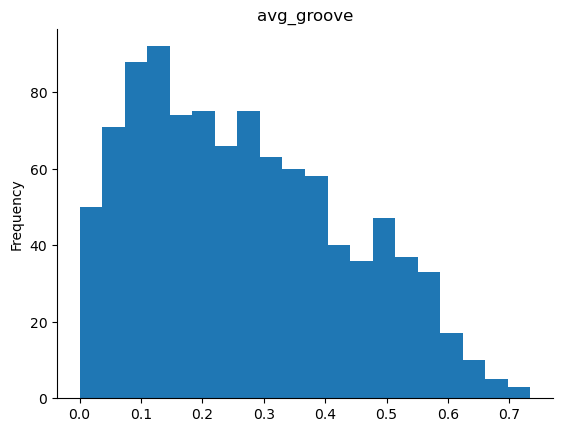

In [67]:
# @title avg_groove

from matplotlib import pyplot as plt
view['avg_groove'].plot(kind='hist', bins=20, title='avg_groove')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [68]:
query='''
SELECT AVG(arousal) AS avg_arousal, music_meta.*
FROM music
INNER JOIN music_meta ON music.instanceId = music_meta.MusicId
GROUP BY instanceId
ORDER BY avg_arousal DESC
'''

view = pd.read_sql_query(query,conn) # tested by Tom (3/4)

In [69]:
view.head(20)

,avg_arousal,MusicId,SourceId,GenreId,Subgenre,Title,Artist,Year,Path
0,5.873367,131,2,3,House,Party Rock Anthem,LMFAO featuring Lauren Bennett and GoonRock,2011,0131_lmfaoFeaturingLaurenBennettAndGoonrock_pa...
1,5.744000,144,2,3,House,Poker Face,Lady Gaga,2009,0144_ladyGaga_pokerFace.mp4
2,5.699900,142,2,3,House,I Gotta Feeling,The Black Eyed Peas,2009,0142_theBlackEyedPeas_iGottaFeeling.mp4
3,5.682460,148,2,3,House,So What,Pink,2008,0148_pink_soWhat.mp4
4,5.668004,133,2,3,House,Moves like Jagger,Maroon 5 featuring Christina Aguilera,2011,0133_maroon5FeaturingChristinaAguilera_movesLi...
5,5.645455,519,5,5,kids dance party,Cupid Shuffle,Cupid,2007,0519_cupid_cupidShuffle.mp4
6,5.607287,132,2,3,House,We Found Love,Rihanna featuring Calvin Harris,2011,0132_rihannaFeaturingCalvinHarris_weFoundLove.mp4
7,5.603604,20,1,5,Pop Punk,American Idiot,Green Day,2004,0020_greenDay_americanIdiot.mp4
8,5.600400,143,2,5,Contemporary,Boom Boom Pow,The Black Eyed Peas,2009,0143_theBlackEyedPeas_boomPow.mp4
9,5.568687,230,4,3,EDM,Levels,Avicii,2011,0230_avicii_levels.mp4


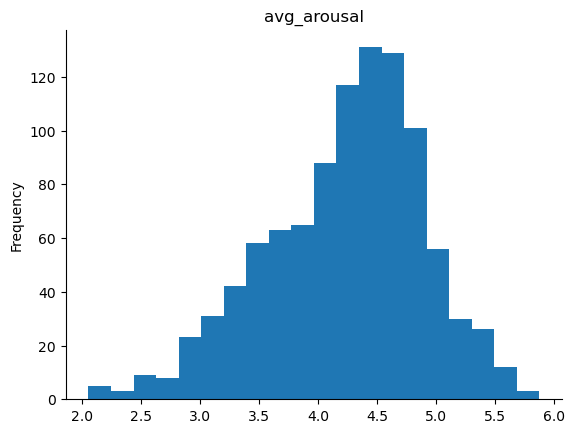

In [70]:
# @title avg_arousal

from matplotlib import pyplot as plt
view['avg_arousal'].plot(kind='hist', bins=20, title='avg_arousal')
plt.gca().spines[['top', 'right',]].set_visible(False)

## avg_rating

In [71]:
query='''
SELECT AVG(rating) AS avg_rating, AVG(rating_reaction_time) AS avg_react, *
FROM music
GROUP BY participantId
ORDER BY avg_rating DESC
'''

view = pd.read_sql_query(query,conn) # tested by Tom (3/4)

In [73]:
view['avg_react']

0       1.464794
1       2.375440
2       2.012235
3       5.193500
4       2.989890
          ...   
1067         NaN
1068         NaN
1069         NaN
1070         NaN
1071         NaN
Name: avg_react, Length: 1072, dtype: float64

# Data Cleaning for Ibrahim's 1024*8000 df

In [ ]:
# Read csv
ibrahim_df = pd.read_csv("/content/drive/MyDrive/FoxLabDataTeam/Machine2/musicDataForIbrahim.csv", header = None)

# Turn each trial into a row
array_list = np.array([ibrahim_df.iloc[i].to_numpy().reshape(400, 20) for i in range(len(ibrahim_df))])
array_list = array_list.reshape(1024*400, 20)
cleaned_ibrahim_df = pd.DataFrame(array_list)

# add participantId column
cleaned_ibrahim_df["participantId"] = 0
for i in range(len(cleaned_ibrahim_df)):
  cleaned_ibrahim_df.iloc[i, len(cleaned_ibrahim_df.columns)-1] = i//400

# Rename and reorder the df
column_list = ["trialTypeId", "trialId", "familiarity", "liking",
               "arousal", "joy", "nostaliga", "groove", "awe",
               "sadness", "anxiety", "disgust", "anger", "nothing",
               "reflection", "boredom", "startTime", "Time1", "Time2", "EndTime"]
cleaned_ibrahim_df = cleaned_ibrahim_df.rename(columns={i:column_list[i] for i in range(len(column_list))})
column_list.insert(0, "participantId")
cleaned_ibrahim_df = cleaned_ibrahim_df[column_list]

In [ ]:
# export df

cleaned_ibrahim_df.to_csv('/content/drive/MyDrive/FoxLabDataTeam/Machine2/cleaned_ibrahim_df.csv', index=False)

# Voice Samples

In [ ]:
path_list = get_mat()

In [ ]:
["j3h3" in i for i in path_list].index(True)

967

In [ ]:
path_list[967]

'j3h3_7385817097.mat'

In [ ]:
mat = loadmat("/content/drive/MyDrive/FoxLabDataTeam/Machine2/all_mat/" + path_list[967])

allTrials = pd.DataFrame(mat['allTrials'])
DATA = pd.DataFrame(mat['DATA'])
seed = pd.DataFrame(mat['seed'])
trainingDATA = pd.DataFrame(mat['trainingDATA'])

In [ ]:
allTrials[allTrials[1] == 6]

,0,1,2
40,41,6,7
42,43,6,1
48,49,6,4
52,53,6,8
348,349,6,9
382,383,6,6
398,399,6,10
498,499,6,11
552,553,6,2
644,645,6,5
